# Calibration of Corona model
This workbook shows how a parameter in the corona model specified [here](Corona%20specify%20model%20and%20make%20eksperiments.ipynb) can be calibrated to match one of the output variables.

The notebook will run when loaded. You can change the cells and run again by press run.  

In [1]:
import os
import pandas as pd

from modelclass import model
from modelinvert import targets_instruments
model.modelflow_auto()

# Load and run
The model and baseline run has been saved in [here](Corona%20specify%20model%20and%20make%20eksperiments.ipynb)

In [2]:
mcorona,df  = model.modelload('coronatest.pcim')  # Get the model and data
df.index = df.index-100                           # rebase the days, so we calibrate at time 0
df.index.name = 'Day'
res = mcorona(df,keep='Basis',silent=1)           # run the baseline 

The model has these input variables: 

 - Spreading 
     - PROBABILITY_TRANSMISION
     - RATE_CONTACT
 - Initial exposed to the disease
     - EXO_EXPOSED
 - Development of disease 
     - NEW_HOSPITAL_TO_RECOVER_RATE',
     - NEW_INFECTIOUS_TO_RECOVER_RATE',
     - NEW_INTENSIVE_TO_RECOVER_RATE',

Also the user has to provide start values for two variables:  
 - POPULATION
 - SUSCEPTIBLE
 
 Day 0 is the day we want to calibrate the model. 
 
 At day -70 10 infected persons came to this population. The parameters has been set to values which gives a growth rate
 of around 12 percent per day. 
 
 Lets look at the input around day 70 (which is the only day where EXO_EXPOSED has a value. The rest is assumed constant. 

In [3]:
df.loc[-71:-69,list(mcorona.exogene)+['POPULATION','SUSCEPTIBLE']].T

Day,-71,-70,-69
NEW_INTENSIVE_TO_RECOVER_RATE,0.60,0.60,0.60
NEW_INFECTIOUS_TO_RECOVER_RATE,0.90,0.90,0.90
EXO_EXPOSED,0.00,10.00,0.00
PROBABILITY_TRANSMISION,0.05,0.05,0.05
NEW_HOSPITAL_TO_RECOVER_RATE,0.01,0.01,0.01
RATE_CONTACT,4.00,4.00,4.00
POPULATION,1000000.00,1000000.00,1000000.00
SUSCEPTIBLE,1000000.00,999990.00,999990.00


# The impact of a change "the probability of transmision"
The number of infected on a day depends on the probability of transmission some days before, and the effect on the number of dead is even more delayes.

Below is the effect of a decrease of 0.01 in the PROBABILITY_TRANSMISION is with different delays is tracked for different output (endogenous) variables.  

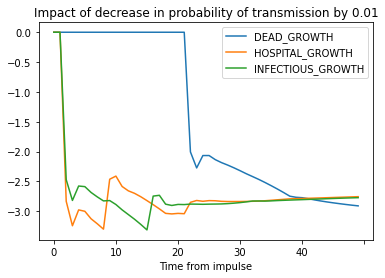

In [4]:
ti = targets_instruments(databank=res,model=mcorona,
                         targets=['DEAD_GROWTH','HOSPITAL_GROWTH','INFECTIOUS_GROWTH'],
                         instruments= [('PROBABILITY_TRANSMISION',-0.01)])
over_delay = pd.concat([ti.jacobi(0,delay=d).rename(columns=lambda x:f'{d}') for d in range(50)],axis=1).T
over_delay.plot.line(title='Impact of decrease in probability of transmission by 0.01',xlabel='Time from impulse');

# Now define a function which calibrates a parameter to match a target output variable
This is a python function which will calibrate the value of an instrument so that the target variable will have a certain value. 

You don't have to understand the python code. The very interested reader can look at the bottom of this notebook for 
a more technical explanation. 

In [5]:
def ti_calibrate(mmodel,instrument,target,value,time,delay=0,silent=1,show=1,keep_restore= False):
    mmodel.keep_solutions,old_keep_solutions= {},mmodel.keep_solutions
    mmodel.keep_solutions['Before calibration'] = mmodel.lastdf.copy(deep=True)
    
    targetdf=pd.DataFrame(value,index=[time],columns=[target])
    ti = targets_instruments(databank=mmodel.lastdf,model=mmodel,targets=targetdf,instruments= [instrument])
    
    res = ti(mmodel.lastdf,delay=delay,silent=1,debug=1)
    res2 = mmodel(res,silent=silent,keep='After calibration')
    if show:
        figs = mcorona.keep_plot(f'{instrument[0]} {target}',diff=0,legend=0,dec='2',showtype='level',scale='linear');
        mmodel.keep_add_vline(figs,time=time) 
    if keep_restore:
        mmodel.keep_solutions,model_calibrate_keep_solutions =  old_keep_solutions,mmodel.keep_solutions
    return res2

# Now calibrate the parameter to match an infectious growth rate of 3 percent 

You can try with different values or variables and the pres the run button. 

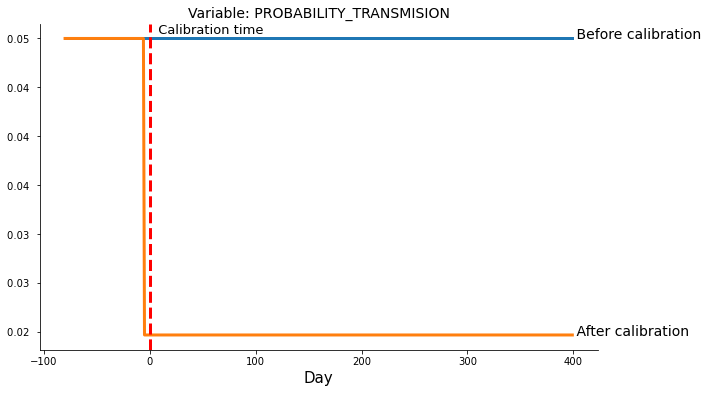

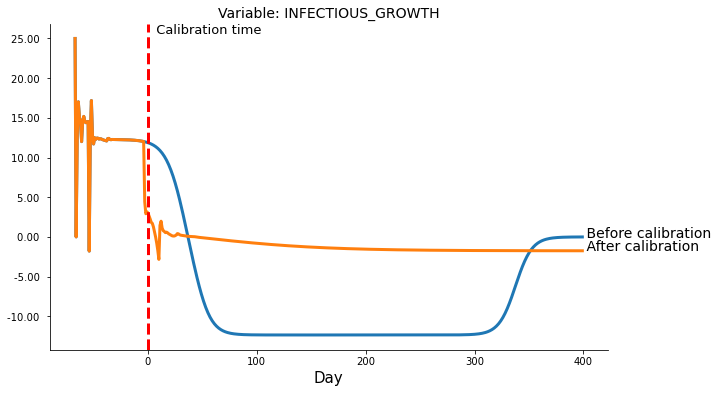

In [6]:
target_value = 3   # the value we want to hit 
time         = 0   # the day we want to calibrate
delay        = 5   # the delay in effect

res = mcorona(df,keep='Basis',silent=1)
res2 = ti_calibrate(mcorona,instrument = ('PROBABILITY_TRANSMISION',0.01),
                    target = 'INFECTIOUS_GROWTH',value=target_value,time=time,delay=delay)

# And plot the results 

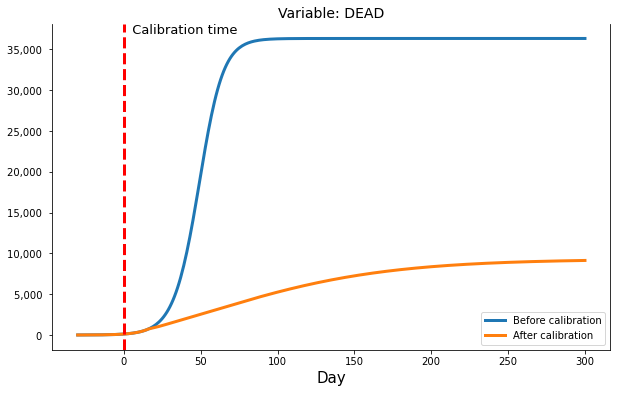

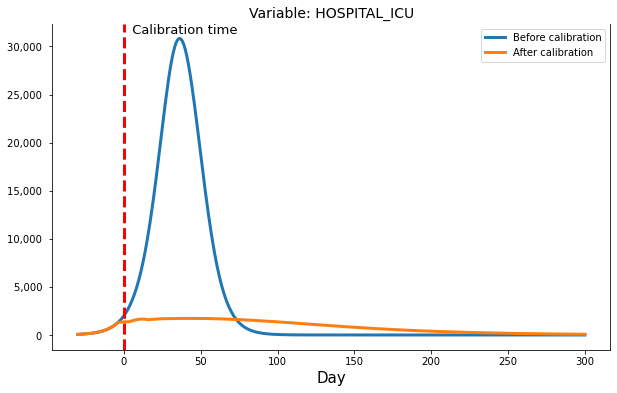

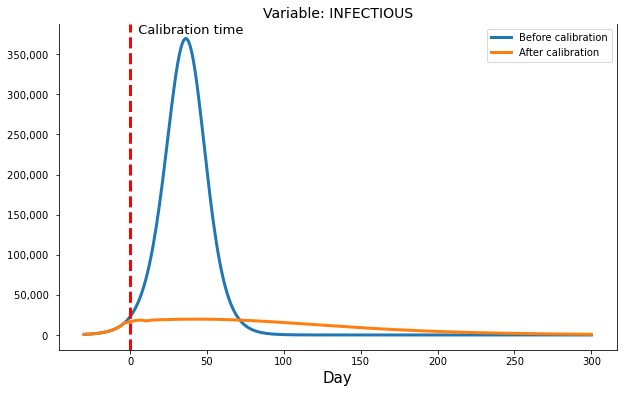

In [7]:
with mcorona.set_smpl(-30,300):
      figs = mcorona.keep_plot('dead hospital_icu infectious',diff=0,legend=1,dec='0',
                                        showtype='level',scale='linear');
      mcorona.keep_add_vline(figs,time=time)

## An explanation of the model inversion (target/instrument) used for calibration. 
**This is a technical note for the interested reader.** 

The problem can be thought as follows: From the generic description of a model: $\textbf{y}_t= \textbf{F}(\textbf{x}_{t})$. Here $\textbf{x}_{t}$ are all predetermined variables - lagged endogenous and all exogenous variables. 

In some models the result depends on the level of exogenous variables with a lag. For instance in a disease spreading model, the *number of infected* on a day depends on the *probability of transmission* some days before. If the *probability of transmission* is the instrument and the *number of infected* is the target. Therefor it can be useful to allow a **delay**, when finding the instruments. In this case we want to look at  $\textbf{y}_t= \textbf{F}(\textbf{x}_{t-delay})$ 

Think of a condensed model ($\textbf{G}$) with a few endogenous variables($\bar{\textbf{y}}_t$):
the targets and a few exogenous variables($\bar{\textbf{x}}_{t-delay}$): the instrument variables. All the rest of the predetermined variables are fixed:  
$\bar{\textbf{y}}_t= \textbf{G}(\bar{\textbf{x}}_{t-delay})$

If we invert G we have a model where  instruments are functions of targets:
$\bar{\textbf{x}_{t-delay}}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}})$. Then all we have to do is to find
$\textbf{G}^{-1}(\bar{\textbf{y}_{t}})$

### And how to solve for the instruments 
For most models $\bar{\textbf{x}}_{t-delay}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}})$ do not have a nice close form solution. However it can be solved numerically. We  turn to Newton–Raphson method.

So $\bar{\textbf{x}}_{t-delay}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}^*})$ will be found using :

for $k$ = 1 to convergence  

>$\bar{\textbf{x}}_{t-delay,end}^k= \bar{\textbf{x}}_{t-delay,end}^{k-1}+ \textbf{J}^{-1}_t \times (\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}^{k-1})$

>$\bar{\textbf{y}}_t^{k}= \textbf{G}(\bar{\textbf{x}}_{t-delay}^{k})$

convergence: $\mid\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}
\mid\leq \epsilon$

Now we just need to find: 

$\textbf{J}_t = \frac{\partial \textbf{G} }{\partial \bar{\textbf{x}}_{t-delay}}$

A number of differentiation methods can be used (symbolic, automated or numerical). ModelFlow uses numerical differentiation, as it is quite simple and fast.

$\textbf{J}_t \approx \frac{\Delta \textbf{G} }{\Delta \bar{\textbf{x}}_{t-delay}}$

That means that we should run the model one time for each instrument, and record the 
effect on each of the targets, then we have $\textbf{J}_t$ 

In order for $\textbf{J}_t$ to be invertible there has to be the same number of targets and instruments. 

However, each instrument can be a basket of exogenous variable. They will be adjusted in fixed proportions. This can be useful for instance when using bank leverage as instruments. Then the leverage instrument can consist of several loan types.  

You will notice that the level of $\bar{\textbf{x}}$ is updated (by  $\textbf{J}^{-1}_t \times (\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}^{k-1})$) in all periods from $t-delay$ to $end$, where $end$ is the last timeframe in the dataframe. This is useful for many applications including calibration of disease spreading models and in economic models, where the instruments are level variable (i.e. not change variables). If this is not suitable, it can be changed in a future release. 

The target/instrument functionality is implemented in the python class `targets_instruments` specified in **ModelFlows** `modelinvert` module.  